In [23]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import _tree
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import AgglomerativeClustering
import plotly.express as px
from pulp import LpProblem, LpVariable, LpMaximize, lpSum, LpStatus, value
from sklearn.decomposition import PCA

import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

In [24]:
df = pd.read_csv("./data/heart.csv")

In [25]:
df = df.rename(
    columns = {'cp':'chest_pain_type', 
               'trestbps':'resting_blood_pressure', 
               'chol': 'cholesterol',
               'fbs': 'fasting_blood_sugar',
               'restecg' : 'resting_electrocardiogram', 
               'thalach': 'max_heart_rate_achieved', 
               'exang': 'exercise_induced_angina',
               'oldpeak': 'st_depression', 
               'slope': 'st_slope', 
               'ca':'num_major_vessels', 
               'thal': 'thalassemia'}, 
    errors="raise")

In [26]:
X = df.drop("target", axis = 1)
y = df[["target"]]

feature_names = X.columns
target_names = y.columns

In [27]:


# Load the breast cancer dataset
# data = load_breast_cancer()
# X = data.data
# y = data.target
# feature_names = data.feature_names
# target_names = data.target_names

X = pd.DataFrame(X, columns = feature_names)
# Train RandomForestClassifier
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X, y)


/Users/DubeyA-Dev/miniconda3/envs/taylor/lib/python3.10/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestClassifier(n_estimators=10, random_state=42)

In [28]:
df

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_electrocardiogram,max_heart_rate_achieved,exercise_induced_angina,st_depression,st_slope,num_major_vessels,thalassemia,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3,0
299,45,1,3,110,264,0,1,132,0,1.2,1,0,3,0
300,68,1,0,144,193,1,1,141,0,3.4,1,2,3,0
301,57,1,0,130,131,0,1,115,1,1.2,1,1,3,0


## Calculating feature usage in decision paths and feature importance based on impurity reduction

/var/folders/tk/qh_5gfz51996p7zxwjyl8r140000gp/T/ipykernel_1775/2676868043.py:98: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=counts, y=features, palette='viridis')


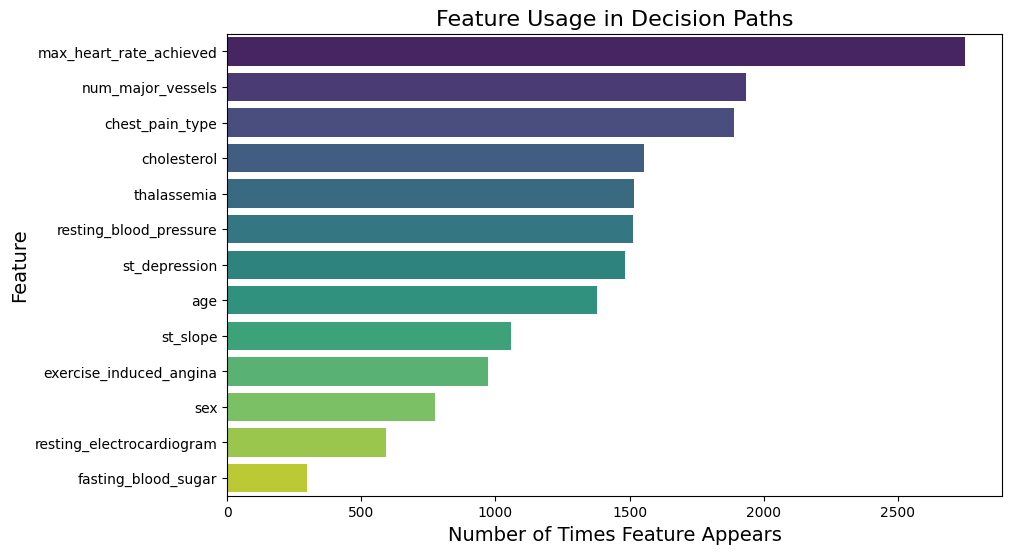

/var/folders/tk/qh_5gfz51996p7zxwjyl8r140000gp/T/ipykernel_1775/2676868043.py:121: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importance, y=features, palette='viridis')


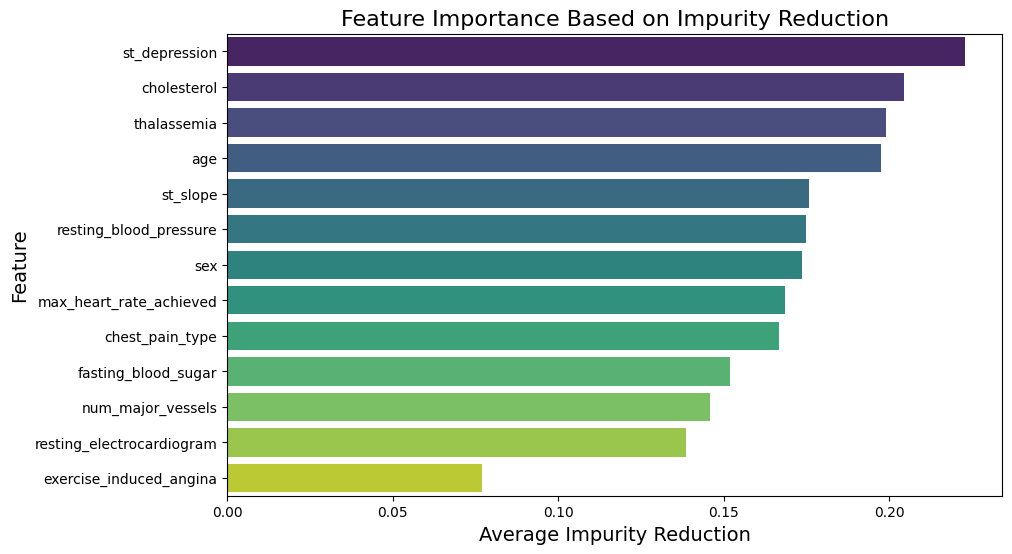

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

def get_decision_paths(model, X):
    decision_paths = []
    
    # Iterate over each tree in the forest
    for tree in model.estimators_:
        tree_paths = extract_tree_paths(tree, X)
        decision_paths.append(tree_paths)
    
    return decision_paths

def extract_tree_paths(tree, X):
    # Get the decision tree structure
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    threshold = tree.tree_.threshold
    value = tree.tree_.value
    
    paths = []
    
    # For each sample in X, trace the path from root to leaf
    for _, sample in X.iterrows():
        path = []
        node = 0  # Start from the root node
        
        while children_left[node] != children_right[node]:  # Not a leaf node
            feature_index = feature[node]
            threshold_value = threshold[node]
            feature_name = X.columns[feature_index]
            
            # Record the decision (feature, threshold, direction)
            if sample[feature_name] <= threshold_value:
                path.append((feature_name, threshold_value, "left"))
                node = children_left[node]
            else:
                path.append((feature_name, threshold_value, "right"))
                node = children_right[node]
        
        # At the leaf node, record the leaf prediction
        leaf_prediction = np.argmax(value[node])
        paths.append((path, leaf_prediction))
    
    return paths

def calculate_split_importance(model):
    importance_weights = []
    
    for tree in model.estimators_:
        tree_importance = extract_split_importance(tree)
        importance_weights.append(tree_importance)
    
    return importance_weights

def extract_split_importance(tree):
    # Get the decision tree structure
    children_left = tree.tree_.children_left
    children_right = tree.tree_.children_right
    feature = tree.tree_.feature
    impurity = tree.tree_.impurity
    
    importance_weights = []
    
    for node in range(tree.tree_.node_count):
        if children_left[node] != children_right[node]:  # Not a leaf node
            feature_index = feature[node]
            left_impurity = impurity[children_left[node]]
            right_impurity = impurity[children_right[node]]
            current_impurity = impurity[node]
            
            # Calculate the impurity reduction (importance weight)
            impurity_reduction = current_impurity - (left_impurity + right_impurity) / 2
            importance_weights.append((feature_index, impurity_reduction))
    
    return importance_weights

def visualize_decision_paths(decision_paths, feature_names):
    feature_count = {feature: 0 for feature in feature_names}
    
    # Count feature usage across all decision paths
    for tree_paths in decision_paths:
        for path, _ in tree_paths:
            for feature, _, _ in path:
                feature_count[feature] += 1

    # Create a bar plot for feature usage count
    feature_usage = list(feature_count.items())
    feature_usage.sort(key=lambda x: x[1], reverse=True)

    features, counts = zip(*feature_usage)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=counts, y=features, palette='viridis')
    plt.title('Feature Usage in Decision Paths', fontsize=16)
    plt.xlabel('Number of Times Feature Appears', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.show()

def visualize_feature_importance(importance_weights, feature_names):
    avg_importance = {feature: [] for feature in feature_names}
    
    # Aggregate importance across all trees
    for tree_importance in importance_weights:
        for feature_index, imp in tree_importance:
            feature_name = feature_names[feature_index]
            avg_importance[feature_name].append(imp)
    
    avg_importance = {feature: np.mean(imp) for feature, imp in avg_importance.items() if imp}
    
    # Sort by importance
    sorted_importance = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)
    features, importance = zip(*sorted_importance)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    sns.barplot(x=importance, y=features, palette='viridis')
    plt.title('Feature Importance Based on Impurity Reduction', fontsize=16)
    plt.xlabel('Average Impurity Reduction', fontsize=14)
    plt.ylabel('Feature', fontsize=14)
    plt.show()

def visualize_decision_trees(model, feature_names, target_names):
    for i, tree in enumerate(model.estimators_):
        plt.figure(figsize=(20, 10))
        plot_tree(tree, feature_names=feature_names, class_names=target_names, filled=True)
        plt.title(f"Decision Tree {i + 1}")
        plt.show()

# Get decision paths and importance weights
decision_paths = get_decision_paths(rf, X)
importance_weights = calculate_split_importance(rf)

# Visualize decision paths
visualize_decision_paths(decision_paths, X.columns)

# Visualize feature importance
visualize_feature_importance(importance_weights, X.columns)

# Visualize decision trees
# visualize_decision_trees(rf, X.columns, target_names)


In [30]:
from sklearn.preprocessing import LabelEncoder

# Function to extract decision paths/rules
def extract_rule_paths(tree, feature_names):
    tree_ = tree.tree_
    feature = tree_.feature
    threshold = tree_.threshold
    rules = []

    def recurse(node, current_rule):
        if tree_.children_left[node] == _tree.TREE_LEAF:
            rule_str = " AND ".join(current_rule)
            rules.append(rule_str)
        else:
            rule_left = f"({feature_names[feature[node]]} <= {threshold[node]:.2f})"
            current_rule.append(rule_left)
            recurse(tree_.children_left[node], current_rule)
            current_rule.pop()

            rule_right = f"({feature_names[feature[node]]} > {threshold[node]:.2f})"
            current_rule.append(rule_right)
            recurse(tree_.children_right[node], current_rule)
            current_rule.pop()

    recurse(0, [])
    return rules

# Custom rule encoder that preserves the structure
def encode_rule_structure(rules):
    encoded_rules = []
    
    # Create a label encoder for feature names (make sure to fit it first)
    feature_encoder = LabelEncoder()
    feature_encoder.fit(feature_names)  # Fit encoder on all feature names
    
    for rule in rules:
        encoded_rule = []
        
        # Split the rule into components and encode
        components = rule.split(" AND ")
        for component in components:
            # Handle the comparison operators and extract feature names
            if "<=" in component:
                feature_name, threshold = component.split(" <= ")
                feature_name = feature_name.strip("()")  # Clean up extra characters
                encoded_rule.append(f"FEAT_{feature_encoder.transform([feature_name])[0]}_LTE_{threshold}")
            elif ">" in component:
                feature_name, threshold = component.split(" > ")
                feature_name = feature_name.strip("()")  # Clean up extra characters
                encoded_rule.append(f"FEAT_{feature_encoder.transform([feature_name])[0]}_GT_{threshold}")
        
        encoded_rules.append(" AND ".join(encoded_rule))
    
    return encoded_rules

# Extract all rules from Random Forest models
all_rule_texts = []
for est in rf.estimators_:
    rules = extract_rule_paths(est, feature_names)
    all_rule_texts.extend(rules)

# Encode the rules
encoded_rules = encode_rule_structure(all_rule_texts)

# Show some of the encoded rules
for i in range(10):
    print(encoded_rules[i])


FEAT_6_LTE_0.50) AND FEAT_12_LTE_2.50) AND FEAT_3_LTE_0.50) AND FEAT_5_LTE_93.00)
FEAT_6_LTE_0.50) AND FEAT_12_LTE_2.50) AND FEAT_3_LTE_0.50) AND FEAT_5_GT_93.00) AND FEAT_7_LTE_139.00) AND FEAT_10_LTE_1.70)
FEAT_6_LTE_0.50) AND FEAT_12_LTE_2.50) AND FEAT_3_LTE_0.50) AND FEAT_5_GT_93.00) AND FEAT_7_LTE_139.00) AND FEAT_10_GT_1.70) AND FEAT_2_LTE_267.00)
FEAT_6_LTE_0.50) AND FEAT_12_LTE_2.50) AND FEAT_3_LTE_0.50) AND FEAT_5_GT_93.00) AND FEAT_7_LTE_139.00) AND FEAT_10_GT_1.70) AND FEAT_2_GT_267.00)
FEAT_6_LTE_0.50) AND FEAT_12_LTE_2.50) AND FEAT_3_LTE_0.50) AND FEAT_5_GT_93.00) AND FEAT_7_GT_139.00) AND FEAT_0_LTE_58.50) AND FEAT_2_LTE_228.50)
FEAT_6_LTE_0.50) AND FEAT_12_LTE_2.50) AND FEAT_3_LTE_0.50) AND FEAT_5_GT_93.00) AND FEAT_7_GT_139.00) AND FEAT_0_LTE_58.50) AND FEAT_2_GT_228.50) AND FEAT_8_LTE_0.50)
FEAT_6_LTE_0.50) AND FEAT_12_LTE_2.50) AND FEAT_3_LTE_0.50) AND FEAT_5_GT_93.00) AND FEAT_7_GT_139.00) AND FEAT_0_LTE_58.50) AND FEAT_2_GT_228.50) AND FEAT_8_GT_0.50) AND FEAT_2_LTE

In [31]:
# Function to decode an encoded rule
def decode_rule_structure(encoded_rules):
    decoded_rules = []

    # Create a label encoder for feature names (must fit the same encoder used for encoding)
    feature_encoder = LabelEncoder()
    feature_encoder.fit(feature_names)  # Fit encoder on all feature names
    
    for encoded_rule in encoded_rules:
        decoded_rule = []
        
        # Split the encoded rule into components
        components = encoded_rule.split(" AND ")
        
        for component in components:
            # Extract the feature index and threshold from the encoded part
            if "_LTE_" in component:  # Handling "<="
                feature_index, threshold = component.split("_LTE_")
                feature_index = int(feature_index.replace("FEAT_", ""))
                decoded_feature = feature_encoder.inverse_transform([feature_index])[0]  # Decode feature name
                decoded_rule.append(f"({decoded_feature} <= {threshold})")
            elif "_GT_" in component:  # Handling ">"
                feature_index, threshold = component.split("_GT_")
                feature_index = int(feature_index.replace("FEAT_", ""))
                decoded_feature = feature_encoder.inverse_transform([feature_index])[0]  # Decode feature name
                decoded_rule.append(f"({decoded_feature} > {threshold})")
        
        decoded_rules.append(" AND ".join(decoded_rule))
    
    return decoded_rules

# Example of decoding the encoded rules
encoded_rule_example = ["FEAT_6_LTE_0.50) AND FEAT_12_LTE_2.50) AND FEAT_3_LTE_0.50) AND FEAT_5_GT_93.00) AND FEAT_7_GT_139.00) AND FEAT_0_LTE_58.50) AND FEAT_2_GT_228.50) AND FEAT_8_GT_0.50) AND FEAT_2_GT_239.00)"]  # Example encoded rule
decoded_rule = decode_rule_structure(encoded_rule_example)

# Show the decoded rule
print(decoded_rule[0])  # Example output: (mean radius <= 15.5) AND (mean smoothness > 20.1)


(num_major_vessels <= 0.50)) AND (thalassemia <= 2.50)) AND (exercise_induced_angina <= 0.50)) AND (max_heart_rate_achieved > 93.00)) AND (resting_blood_pressure > 139.00)) AND (age <= 58.50)) AND (cholesterol > 228.50)) AND (resting_electrocardiogram > 0.50)) AND (cholesterol > 239.00))


In [32]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import AgglomerativeClustering

# Step 1: Vectorize the encoded rules using CountVectorizer or TfidfVectorizer
vectorizer = CountVectorizer()  # You can also try TfidfVectorizer
encoded_rule_vectors = vectorizer.fit_transform(encoded_rules)

# Step 2: Perform hierarchical clustering on the vectorized encoded rules
n_clusters = 5
clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='cosine', linkage='average')
labels = clustering.fit_predict(encoded_rule_vectors.toarray())

# Step 3: Group the rules by their clusters
clustered_rules = {i: [] for i in range(n_clusters)}
for encoded_rule, label in zip(encoded_rules, labels):
    clustered_rules[label].append(encoded_rule)

# Example: Print some clustered rules
for cluster_id, rules in clustered_rules.items():
    print(f"Cluster {cluster_id}:")
    for rule in rules[:5]:  # Show first 5 rules in each cluster
        print(f"  {rule}")
    print("\n")


Cluster 0:
  FEAT_6_LTE_0.50) AND FEAT_12_LTE_2.50) AND FEAT_3_LTE_0.50) AND FEAT_5_LTE_93.00)
  FEAT_6_LTE_0.50) AND FEAT_12_LTE_2.50) AND FEAT_3_LTE_0.50) AND FEAT_5_GT_93.00) AND FEAT_7_LTE_139.00) AND FEAT_10_LTE_1.70)
  FEAT_6_LTE_0.50) AND FEAT_12_LTE_2.50) AND FEAT_3_LTE_0.50) AND FEAT_5_GT_93.00) AND FEAT_7_LTE_139.00) AND FEAT_10_GT_1.70) AND FEAT_2_LTE_267.00)
  FEAT_6_LTE_0.50) AND FEAT_12_LTE_2.50) AND FEAT_3_LTE_0.50) AND FEAT_5_GT_93.00) AND FEAT_7_LTE_139.00) AND FEAT_10_GT_1.70) AND FEAT_2_GT_267.00)
  FEAT_6_LTE_0.50) AND FEAT_12_LTE_2.50) AND FEAT_3_LTE_0.50) AND FEAT_5_GT_93.00) AND FEAT_7_GT_139.00) AND FEAT_0_LTE_58.50) AND FEAT_2_LTE_228.50)


Cluster 1:
  FEAT_10_GT_1.70) AND FEAT_12_LTE_2.50) AND FEAT_6_GT_0.50)
  FEAT_10_GT_1.70) AND FEAT_12_GT_2.50) AND FEAT_1_LTE_2.50)
  FEAT_10_GT_1.70) AND FEAT_12_GT_2.50) AND FEAT_1_GT_2.50) AND FEAT_0_LTE_47.00)
  FEAT_10_GT_1.70) AND FEAT_12_GT_2.50) AND FEAT_1_GT_2.50) AND FEAT_0_GT_47.00)


Cluster 2:
  FEAT_12_LTE_2.5

In [33]:
for cluster_id, rules in clustered_rules.items():
    print(f"Cluster {cluster_id}:")
    for rule in rules[:5]:  # Show first 5 rules in each cluster
        print(f"  {rule}")
    print("\n")

Cluster 0:
  FEAT_6_LTE_0.50) AND FEAT_12_LTE_2.50) AND FEAT_3_LTE_0.50) AND FEAT_5_LTE_93.00)
  FEAT_6_LTE_0.50) AND FEAT_12_LTE_2.50) AND FEAT_3_LTE_0.50) AND FEAT_5_GT_93.00) AND FEAT_7_LTE_139.00) AND FEAT_10_LTE_1.70)
  FEAT_6_LTE_0.50) AND FEAT_12_LTE_2.50) AND FEAT_3_LTE_0.50) AND FEAT_5_GT_93.00) AND FEAT_7_LTE_139.00) AND FEAT_10_GT_1.70) AND FEAT_2_LTE_267.00)
  FEAT_6_LTE_0.50) AND FEAT_12_LTE_2.50) AND FEAT_3_LTE_0.50) AND FEAT_5_GT_93.00) AND FEAT_7_LTE_139.00) AND FEAT_10_GT_1.70) AND FEAT_2_GT_267.00)
  FEAT_6_LTE_0.50) AND FEAT_12_LTE_2.50) AND FEAT_3_LTE_0.50) AND FEAT_5_GT_93.00) AND FEAT_7_GT_139.00) AND FEAT_0_LTE_58.50) AND FEAT_2_LTE_228.50)


Cluster 1:
  FEAT_10_GT_1.70) AND FEAT_12_LTE_2.50) AND FEAT_6_GT_0.50)
  FEAT_10_GT_1.70) AND FEAT_12_GT_2.50) AND FEAT_1_LTE_2.50)
  FEAT_10_GT_1.70) AND FEAT_12_GT_2.50) AND FEAT_1_GT_2.50) AND FEAT_0_LTE_47.00)
  FEAT_10_GT_1.70) AND FEAT_12_GT_2.50) AND FEAT_1_GT_2.50) AND FEAT_0_GT_47.00)


Cluster 2:
  FEAT_12_LTE_2.5

1. **Explaining TF-IDF Preservation of Rule Structure**: This involves explaining how the feature encoding and the use of TF-IDF help preserve the logical structure of the rules (like mathematical operators and conditions) even after encoding feature names and thresholds.



### TF-IDF and Rule Structure Preservation

When you encode rules, you need to preserve the logical structure (`<`, `>`, `=`, `AND`, `OR`) to maintain interpretability. TF-IDF (Term Frequency-Inverse Document Frequency) is traditionally used for text data, but when you use it for rules, we need to map the rule’s logical structure into features that TF-IDF can handle, ensuring the structure is preserved.

#### Explanation of TF-IDF in Rule Encoding

1. **Feature and Threshold Encoding**: The features in the rule, like `FEAT_8_LTE_0.09`, are encoded using a consistent naming convention like `FEAT_8_LTE_0.09`. The feature names (`FEAT_8`) and thresholds (`0.09`) are preserved directly as terms.
   
   Example:
   - Original rule: `FEAT_8 <= 0.09 AND FEAT_20 > 957.45`
   - Encoded rule (for TF-IDF): `FEAT_8_LTE_0.09 AND FEAT_20_GT_957.45`

2. **Mathematical Operators**: The logical operators like `<=`, `>`, and `AND` are encoded as part of the feature strings, allowing TF-IDF to capture the interaction between features and thresholds.
   - The `<=` or `>` becomes part of the feature string, ensuring that the direction of the condition is preserved.
   - The logical `AND` (and potentially `OR`) operators link the conditions together, so they are recognized as connected terms in the rule.

3. **Preservation of Rule Structure**: When rules are encoded into feature vectors using TF-IDF:
   - **Term Frequency (TF)** captures how frequently a feature or condition appears across all rules. This tells you the "importance" of that feature in the decision rules.
   - **Inverse Document Frequency (IDF)** highlights features that are rarer, giving higher importance to features that occur less frequently but still contribute to distinguishing between classes.
   
   This structure is preserved because the individual conditions like `FEAT_8_LTE_0.09`, `FEAT_20_GT_957.45`, and the logical operators like `AND` are treated as individual terms. The interactions between them are captured in the vectorized form.

#### Example: Encoding Preservation

Let's consider the rule `FEAT_8 <= 0.09 AND FEAT_20 > 957.45`. After encoding:

- `FEAT_8_LTE_0.09` will be a term.
- `FEAT_20_GT_957.45` will be another term.
- `AND` is treated as a logical separator that helps relate these terms to one another.

Using TF-IDF, the model will generate a vector where:
- The presence or absence of terms like `FEAT_8_LTE_0.09` and `FEAT_20_GT_957.45` is captured.
- The logical relationship (like `AND`) between the terms remains part of the rule, maintaining the interpretability of the model.

### Final Thoughts

- **Parallel Coordinates**: This will help visualize how the feature values are influencing the predictions across different rules, showing which rules contribute to a prediction of `1` or `0`.
- **TF-IDF Preservation**: By encoding features and conditions as terms, TF-IDF preserves the logical structure of the rules. This encoding process ensures that the logical connections between features, thresholds, and logical operators are captured, allowing for interpretable rule-based explanations.

In [34]:
# 5. Visualize the clusters
# Create a DataFrame for the clusters and rules
cluster_df = pd.DataFrame({
    'Cluster': labels,
    'Rule': all_rule_texts
})



Rule: FEAT_6_LTE_0.50) AND FEAT_12_LTE_2.50) AND FEAT_3_LTE_0.50) AND FEAT_5_LTE_93.00)
Extracted Conditions: [('6', '0.50'), ('12', '2.50'), ('3', '0.50'), ('5', '93.00')]
Matching Features: ['resting_electrocardiogram', 'thalassemia', 'resting_blood_pressure', 'fasting_blood_sugar']
Rule: FEAT_6_LTE_0.50) AND FEAT_12_LTE_2.50) AND FEAT_3_LTE_0.50) AND FEAT_5_GT_93.00) AND FEAT_7_LTE_139.00) AND FEAT_10_LTE_1.70)
Extracted Conditions: [('6', '0.50'), ('12', '2.50'), ('3', '0.50'), ('5', '93.00'), ('7', '139.00'), ('10', '1.70')]
Matching Features: ['resting_electrocardiogram', 'thalassemia', 'resting_blood_pressure', 'fasting_blood_sugar', 'max_heart_rate_achieved', 'st_slope']
Rule: FEAT_6_LTE_0.50) AND FEAT_12_LTE_2.50) AND FEAT_3_LTE_0.50) AND FEAT_5_GT_93.00) AND FEAT_7_LTE_139.00) AND FEAT_10_GT_1.70) AND FEAT_2_LTE_267.00)
Extracted Conditions: [('6', '0.50'), ('12', '2.50'), ('3', '0.50'), ('5', '93.00'), ('7', '139.00'), ('10', '1.70'), ('2', '267.00')]
Matching Features: ['re

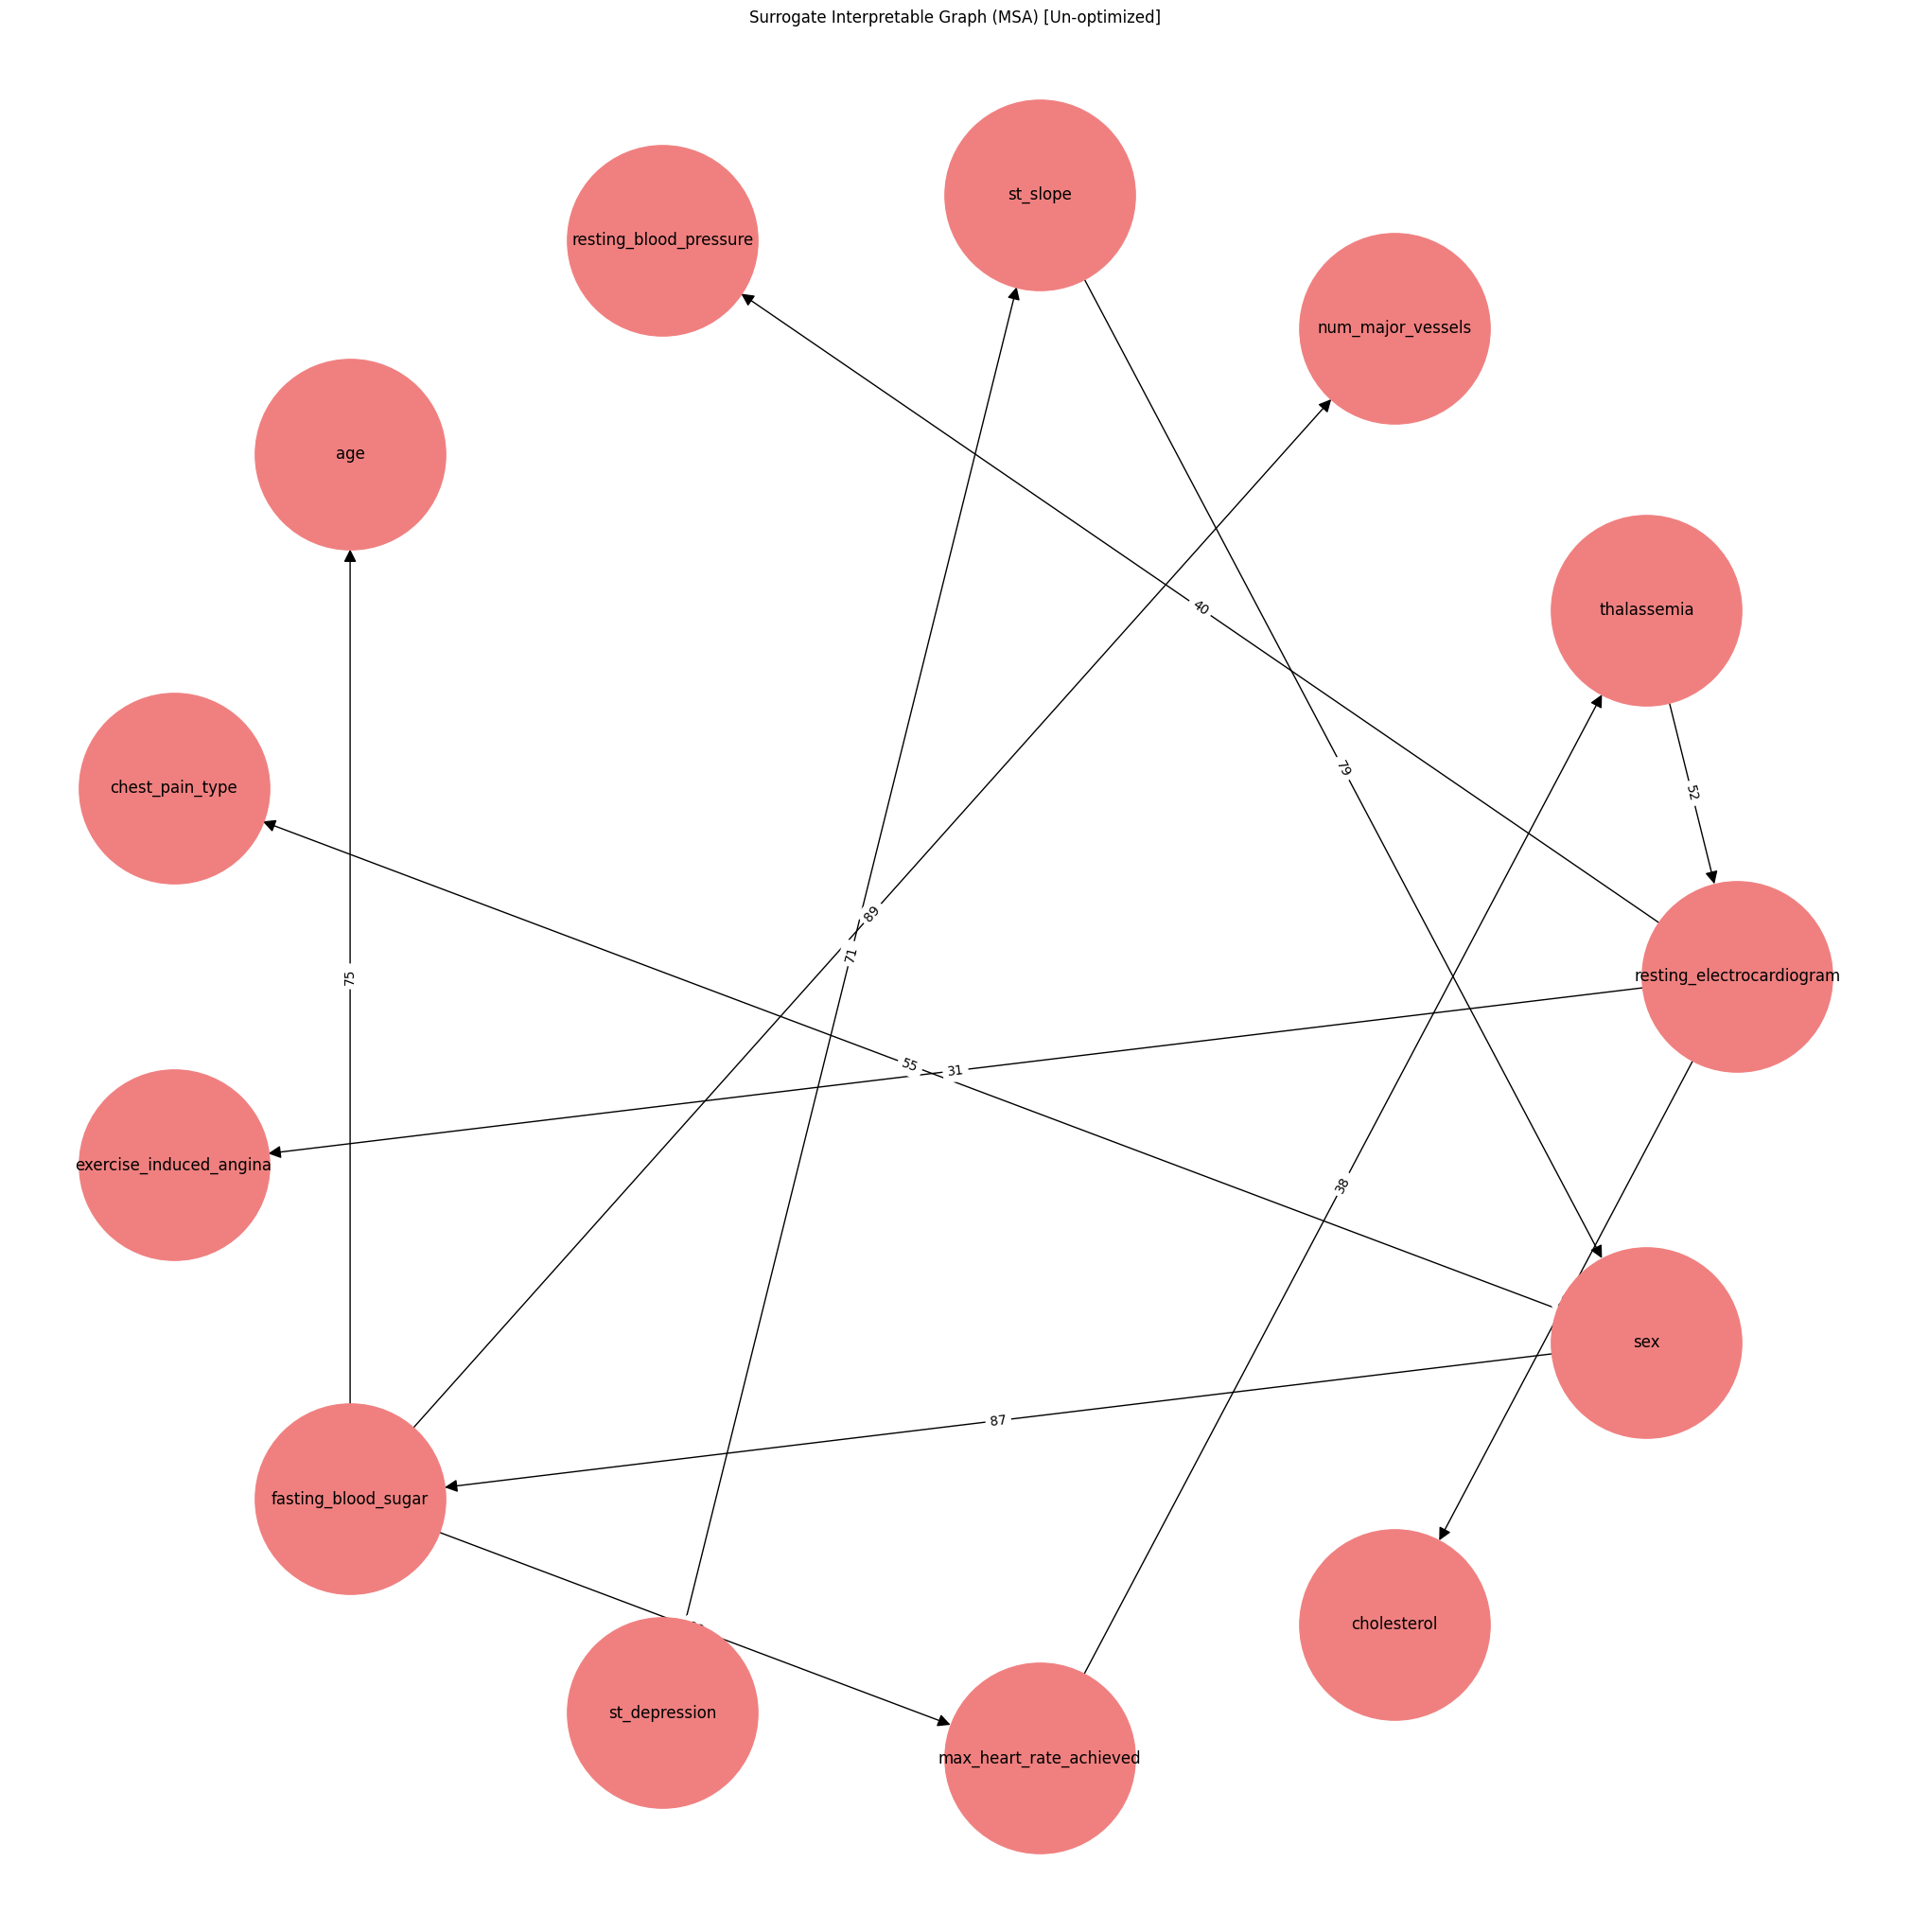

CPU times: user 1.05 s, sys: 17.8 ms, total: 1.07 s
Wall time: 388 ms


In [36]:
%%time
# Mapping from encoded feature names to actual feature names
feature_mapping = {f"FEAT_{i}": feature for i, feature in enumerate(X.columns)}

# Initialize edge weights
edge_weights = {}

# Debug: Check rule extraction and feature matching
for rule_text in encoded_rules:
    # Extract the features and thresholds
    conditions = re.findall(r'FEAT_(\d+)_\w+_([\d\.]+)', rule_text)
    
    # Debug: Print the extracted features and thresholds
    print(f"Rule: {rule_text}")
    print(f"Extracted Conditions: {conditions}")

    # Map FEAT_0, FEAT_1, ... back to actual feature names in the dataset
    features_in_rule = [feature_mapping[f"FEAT_{cond[0]}"] for cond in conditions if f"FEAT_{cond[0]}" in feature_mapping]

    # Debug: Print the features that match the dataset
    print(f"Matching Features: {features_in_rule}")

    # If features are valid, build the edges
    if len(features_in_rule) > 1:
        for i in range(len(features_in_rule) - 1):
            edge = (features_in_rule[i], features_in_rule[i+1])
            edge_weights[edge] = edge_weights.get(edge, 0) + 1

# Create a directed graph using networkx
G = nx.DiGraph()

# Add edges and their weights to the graph
for (f_from, f_to), weight in edge_weights.items():
    G.add_edge(f_from, f_to, weight=weight)

# # Debug: Check the graph before proceeding
# print(f"Graph Nodes: {list(G.nodes())}")
# print(f"Graph Edges: {list(G.edges(data=True))}")

# Create a reversed graph (H) with negated weights for minimum spanning arborescence
H = nx.DiGraph()
for u, v, d in G.edges(data=True):
    H.add_edge(u, v, weight=-d['weight'])

# Compute the Minimum Spanning Arborescence (MSA)
if len(list(H.nodes())) > 0:
    root = list(H.nodes())[0]  # Choose an arbitrary root node
    msa = nx.minimum_spanning_arborescence(H)

    # Revert the edge weights to positive after the spanning tree computation
    for u, v, d in msa.edges(data=True):
        d['weight'] = -d['weight']
    
    # Plot the graph
    plt.figure(figsize=(20, 20))
    pos = nx.circular_layout(msa)  # Using circular layout for better visualization
    edge_labels = nx.get_edge_attributes(msa, 'weight')

    # Draw the nodes, edges, and edge labels
    nx.draw(msa, pos, with_labels=True, node_size=21000, node_color="lightcoral", arrowsize=20)
    nx.draw_networkx_edge_labels(msa, pos, edge_labels=edge_labels)

    plt.title("Surrogate Interpretable Graph (MSA) [Un-optimized]")
    plt.show()
else:
    print("Graph H is empty. No feature transitions were detected.")


### MILP Optimization of the Surrogate Interpretable Graph of the RF Classifier


##### Simple Linear Optimizer

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/DubeyA-Dev/miniconda3/envs/taylor/lib/python3.10/site-packages/pulp/apis/../solverdir/cbc/osx/i64/cbc /var/folders/tk/qh_5gfz51996p7zxwjyl8r140000gp/T/1e5bc53adc5044db8d4e47f90c582d10-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/tk/qh_5gfz51996p7zxwjyl8r140000gp/T/1e5bc53adc5044db8d4e47f90c582d10-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 6 COLUMNS
At line 579 RHS
At line 581 BOUNDS
At line 725 ENDATA
Problem MODEL has 1 rows, 143 columns and 143 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 944 - 0.00 seconds
Cgl0004I processed model has 1 rows, 141 columns (141 integer (139 of which binary)) and 141 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of

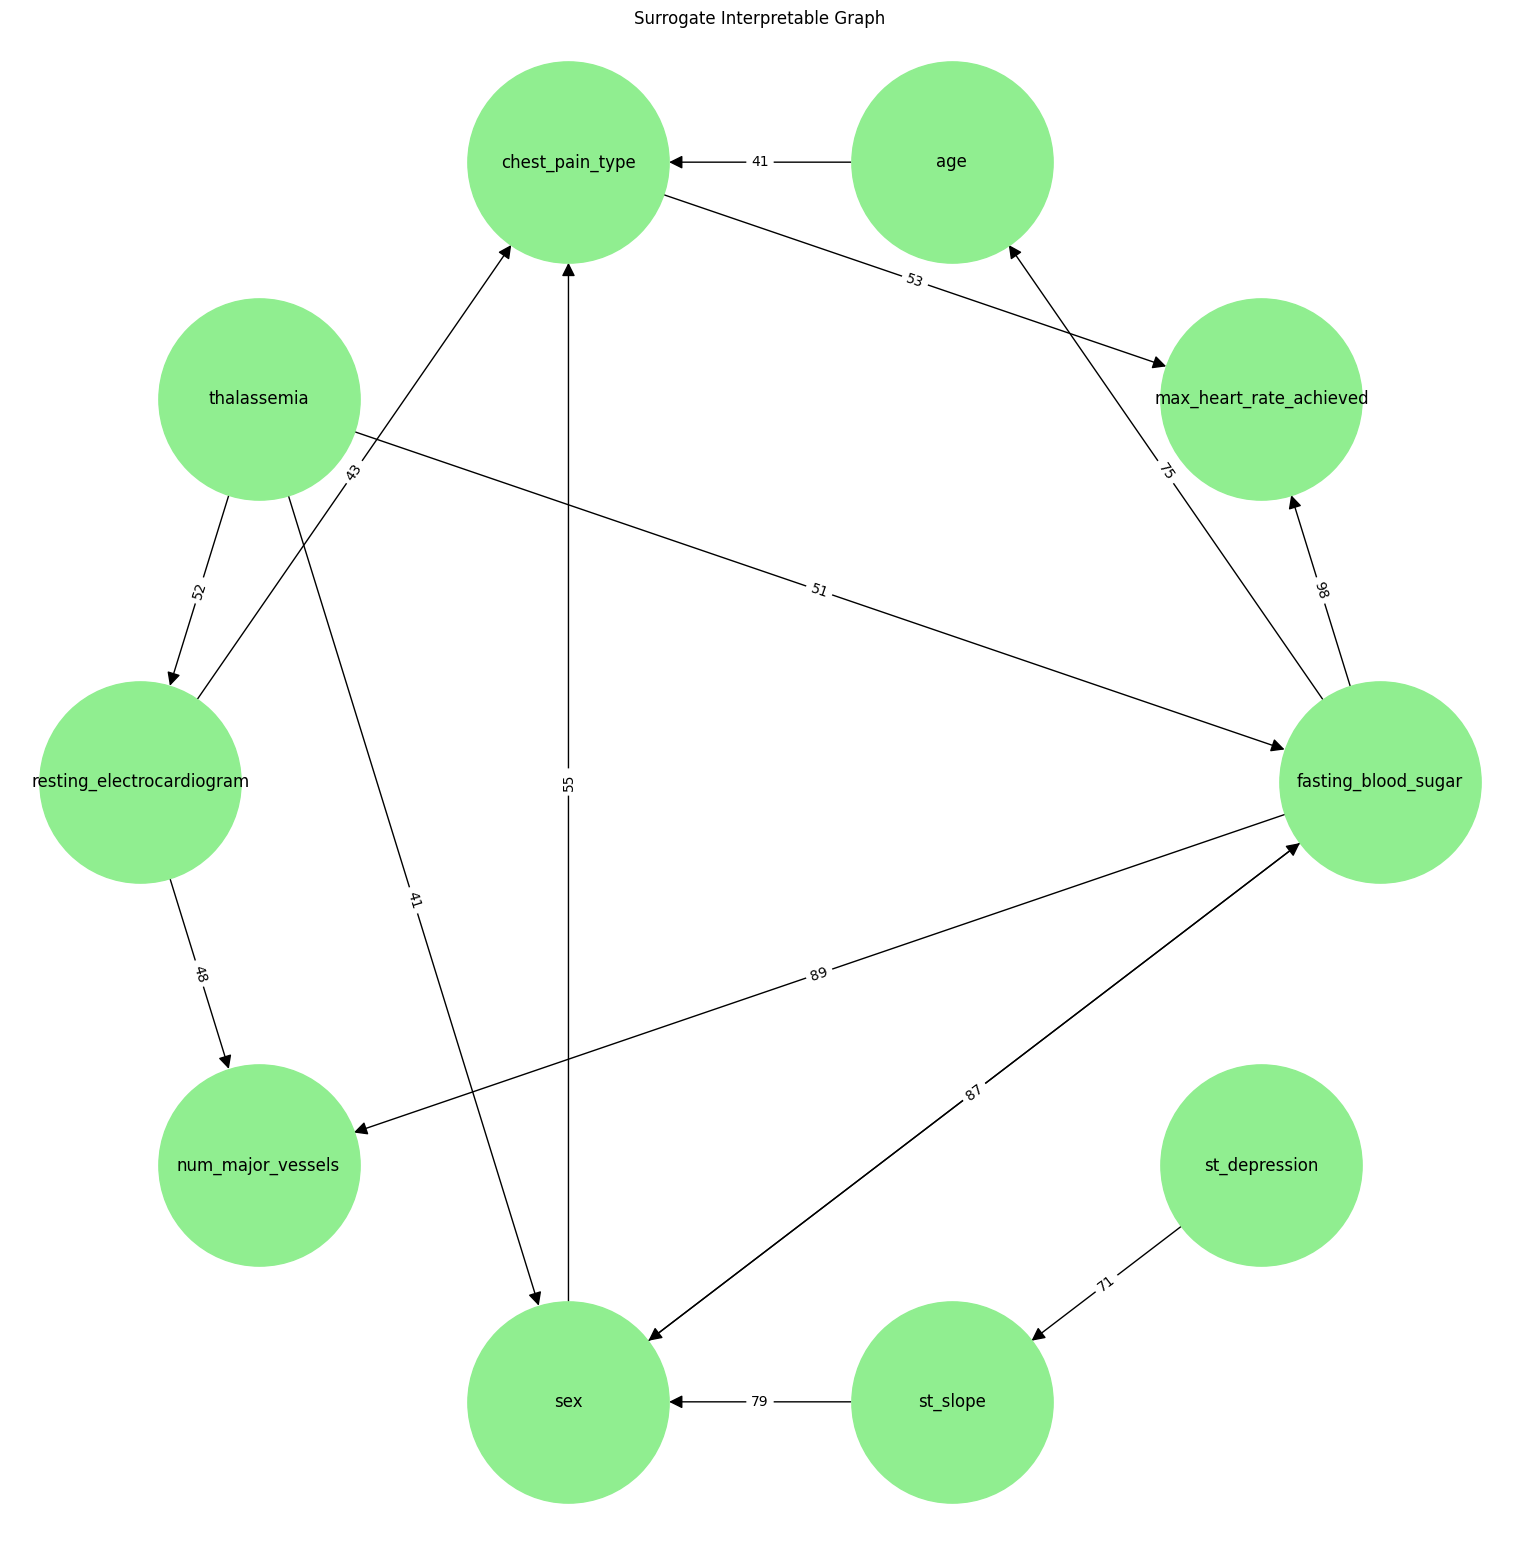

In [37]:
import networkx as nx
import matplotlib.pyplot as plt
from pulp import LpProblem, LpMaximize, LpVariable, lpSum, LpStatus

# 1. Mapping from encoded feature names to actual feature names
feature_mapping = {f"FEAT_{i}": feature for i, feature in enumerate(X.columns)}

# 2. Define edge weights (using previous code)
edge_weights = {}

# Debug: Check rule extraction and feature matching
for rule_text in encoded_rules:
    # Extract the features and thresholds
    conditions = re.findall(r'FEAT_(\d+)_\w+_([\d\.]+)', rule_text)
    
    # Map FEAT_0, FEAT_1, ... back to actual feature names in the dataset
    features_in_rule = [feature_mapping[f"FEAT_{cond[0]}"] for cond in conditions if f"FEAT_{cond[0]}" in feature_mapping]

    # If features are valid, build the edges
    if len(features_in_rule) > 1:
        for i in range(len(features_in_rule) - 1):
            edge = (features_in_rule[i], features_in_rule[i+1])
            edge_weights[edge] = edge_weights.get(edge, 0) + 1

# 3. Define maximum number of edges to select (surrogate graph size)
max_edges = 15

# 4. Create MILP problem: maximize sum of weights of selected edges subject to selecting <= max_edges.
prob = LpProblem("Surrogate_Graph_Selection", LpMaximize)

# 5. Create a binary variable for each edge in edge_dict
edge_vars = {edge: LpVariable(f"edge_{edge[0]}_{edge[1]}", cat='Binary')
             for edge in edge_weights.keys()}

# 6. Objective: maximize total weight of selected edges
prob += lpSum([edge_weights[edge] * edge_vars[edge] for edge in edge_vars]), "Total_Weight"

# 7. Constraint: number of selected edges <= max_edges
prob += lpSum([edge_vars[edge] for edge in edge_vars]) <= max_edges, "EdgeCountConstraint"

# 8. Solve the MILP problem
prob.solve()

print("MILP Status:", LpStatus[prob.status])

# 9. Extract selected edges from the MILP solution
# 9. Extract selected edges from the MILP solution
selected_edges = [edge for edge in edge_vars if edge_vars[edge].value() == 1]
print("Selected edges for surrogate graph:", selected_edges)


# 10. Build surrogate graph from selected edges
G_surrogate = nx.DiGraph()
for edge in selected_edges:
    G_surrogate.add_edge(edge[0], edge[1], weight=edge_weights[edge])

# 11. Visualize the surrogate graph
plt.figure(figsize=(15, 15))
pos = nx.circular_layout(G_surrogate)
edge_labels = nx.get_edge_attributes(G_surrogate, 'weight')
nx.draw(G_surrogate, pos, with_labels=True, node_size=21000, node_color="lightgreen", arrowsize=20)
nx.draw_networkx_edge_labels(G_surrogate, pos, edge_labels=edge_labels)
plt.title("Surrogate Interpretable Graph")
plt.show()


## Analyzing conuterfactual for each of the tree within the search limit parameters


**What the Function Does:**
1. For each feature, tries to find the smallest perturbation (±step size) needed to flip the model's prediction
2. Tests both positive and negative directions for each feature
3. Stops searching when either:
   - Prediction flips (found counterfactual)
   - Reaches maximum iterations without flipping (no counterfactual)

**Why No Counterfactuals Are Produced:**
1. **Model Robustness**: The model might be too confident in its prediction (needs larger perturbations)
2. **Feature Interactions**: Real decisions often require coordinated changes in multiple features
3. **Search Limitations**: 
   - Step size (0.05) might be too small
   - Max iterations (50) might be insufficient (max change = 50×0.05 = 2.5 units)
4. **Data Distribution**: Changes might need to stay within valid feature ranges
5. **Binary Search Limitation**: Only modifies one feature at a time

**Enhanced Version with Visualization and Improvements:**


1. **Probability Tracking**: Monitors class probability evolution instead of just class labels
2. **Visualization**: Shows how probabilities evolve with positive/negative perturbations
3. **Directional Analysis**: Separate tracking of increase/decrease directions
4. **Adaptive Step Size**: Larger default step (0.1) for faster exploration
5. **Target Class Specification**: Explicit target class control
6. **Diagnostic Plotting**: Reveals:
   - Probability trajectories
   - Decision boundary (0.5 line)
   - Relative feature sensitivity

**Interpretation Guide:**
1. **No Counterfactuals Indicate**:
   - Flat lines: Feature changes don't affect predictions
   - Non-crossing curves: Changes insufficient to flip class
2. **Steep Curves**: Sensitive features that impact predictions
3. **Crossing 0.5 Line**: Successful counterfactual found

**Common Reasons for No Results:**
1. **Insufficient Perturbation Space**: Try:
2. **Need Multi-Feature Changes**: Combine features showing partial probability shifts
3. **Model Linearity Issues**: Try non-uniform step sizes or optimization-based methods
4. **Data Constraints**: Add range checks for valid feature values

## Counterfactual for each tree (aggregate analysis) of the RF Classifier

**Key Features:**
1. **Per-Tree Analysis**: Evaluates counterfactual effectiveness for each individual decision tree
2. **Four Diagnostic Visualizations**:
   - Success rate heatmap across features
   - Perturbation magnitude distribution
   - Direction consistency plot
   - Decision boundary projection for top feature
3. **Aggregate Statistics**:
   - Success rates across the ensemble
   - Required perturbation magnitudes
   - Direction consistency metrics

**Interpretation Guide:**
1. **No Counterfactuals Possible When**:
   - Success rate heatmap shows all low values (0-0.2)
   - Perturbation magnitude plot shows sparse/no points
   - Decision boundary projection shows instance far from boundary

2. **Key Insights**:
   - Features with high success rates are good candidate for intervention
   - Consistent direction across trees indicates robust relationships
   - Large required deltas suggest feature scaling issues or model robustness

This analysis helps understand why counterfactuals might be hard to find by:
- Revealing feature-specific effectiveness across the ensemble
- Showing required intervention magnitudes
- Visualizing decision boundaries for critical features
- Identifying directional consistency in required perturbations

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.inspection import DecisionBoundaryDisplay

def ensemble_counterfactual_analysis(instance, rf_model, feature_names, 
                                    step=0.5, max_iter=500, target_class=None):
    """
    Advanced counterfactual analysis across Random Forest subtrees
    Returns:
    - (dict) Aggregate counterfactual statistics per feature
    - (dict) Individual tree counterfactual data
    - (matplotlib.figure) Visualizations
    """
    # Initialize data structures
    n_trees = len(rf_model.estimators_)
    n_features = len(feature_names)
    tree_data = []
    aggregate_results = {feat: {'deltas': [], 'success_rate': 0} 
                        for feat in feature_names}
    
    # Create progress bar for tree analysis
    with tqdm(total=n_trees, desc="Analyzing Subtrees") as pbar:
        for tree_idx, tree in enumerate(rf_model.estimators_):
            # Get original prediction from this subtree
            orig_pred = tree.predict(instance.reshape(1, -1))[0]
            target = 1 - orig_pred if target_class is None else target_class
            
            tree_results = {}
            
            # Analyze each feature
            for feat_idx, feat_name in enumerate(feature_names):
                found_cf = False
                # Try both perturbation directions
                for direction in [-1, 1]:
                    perturbed = instance.copy()
                    for i in range(max_iter):
                        perturbed[feat_idx] += direction * step * (i+1)
                        new_pred = tree.predict(perturbed.reshape(1, -1))[0]
                        if new_pred == target:
                            tree_results[feat_name] = {
                                'delta': direction * step * (i+1),
                                'iterations': i+1,
                                'direction': 'decrease' if direction == -1 else 'increase'
                            }
                            aggregate_results[feat_name]['deltas'].append(direction * step * (i+1))
                            found_cf = True
                            break
                    if found_cf:
                        break
                if not found_cf:
                    tree_results[feat_name] = {'delta': np.nan, 'iterations': max_iter}
            
            tree_data.append(tree_results)
            pbar.update(1)
    
    # Calculate success rates
    for feat in aggregate_results:
        successes = len([d for d in aggregate_results[feat]['deltas'] if not np.isnan(d)])
        aggregate_results[feat]['success_rate'] = successes / n_trees
    
    # Generate visualizations
    plt.figure(figsize=(30, 28))
    
    # 1. Feature Importance Heatmap
    plt.subplot(2, 2, 1)
    success_rates = [aggregate_results[feat]['success_rate'] for feat in feature_names]
    plt.imshow(np.array(success_rates).reshape(1, -1), cmap='viridis', aspect='auto')
    plt.colorbar(label='Success Rate')
    plt.yticks([])
    plt.xticks(np.arange(len(feature_names)), feature_names, rotation=90)
    plt.title('Counterfactual Success Rate Across Trees')
    
    # 2. Delta Distribution Swarm Plot
    plt.subplot(2, 2, 2)
    all_deltas = []
    for feat in feature_names:
        deltas = [d for d in aggregate_results[feat]['deltas'] if not np.isnan(d)]
        jitter = np.random.normal(loc=0, scale=0.1, size=len(deltas))
        plt.scatter(np.arange(len(deltas)) + jitter, deltas, 
                    alpha=0.3, label=feat)
    plt.axhline(0, color='gray', linestyle='--')
    plt.ylabel('Required Delta')
    plt.xlabel('Feature Index')
    plt.title('Perturbation Magnitude Distribution')
    
    # 3. Direction Consistency Plot
    plt.subplot(2, 2, 3)
    direction_counts = {feat: {'increase': 0, 'decrease': 0} 
                       for feat in feature_names}
    for tree in tree_data:
        for feat, res in tree.items():
            if 'direction' in res:
                direction_counts[feat][res['direction']] += 1
                
    width = 0.4
    for idx, feat in enumerate(feature_names):
        plt.bar(idx - width/2, direction_counts[feat]['increase'], 
               width=width, color='green')
        plt.bar(idx + width/2, direction_counts[feat]['decrease'], 
               width=width, color='red')
    plt.xticks(np.arange(len(feature_names)), feature_names, rotation=90)
    plt.ylabel('Count')
    plt.title('Direction Consistency Across Trees')
    plt.legend(['Increase', 'Decrease'])
    
    # 4. Decision Boundary Projection
    plt.subplot(2, 2, 4)
    top_feature = sorted(feature_names, 
                        key=lambda x: aggregate_results[x]['success_rate'])[-1]
    feat_idx = feature_names.index(top_feature)
    
    # Generate probability curve for top feature
    feat_values = np.linspace(instance[feat_idx] - 3*step*max_iter,
                            instance[feat_idx] + 3*step*max_iter, 100)
    probabilities = []
    
    for val in feat_values:
        modified = instance.copy()
        modified[feat_idx] = val
        # Get average probability across all trees
        avg_prob = np.mean([tree.predict_proba(modified.reshape(1, -1))[0][target_class] 
                          for tree in rf_model.estimators_])
        probabilities.append(avg_prob)
    
    plt.plot(feat_values, probabilities, color='navy', lw=2)
    plt.axvline(instance[feat_idx], color='red', linestyle='--', label='Original Value')
    plt.axhline(0.5, color='gray', linestyle=':', label='Decision Threshold')
    plt.xlabel(top_feature)
    plt.ylabel('Average Class Probability')
    plt.title(f'Probability Landscape for {top_feature}')
    plt.legend()
    
    plt.tight_layout()
    return aggregate_results, tree_data

#### This also enables directional consistency evaluations

/Users/DubeyA-Dev/miniconda3/envs/taylor/lib/python3.10/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
Analyzing Subtrees: 100%|██████████| 10/10 [00:00<00:00, 18.28it/s]


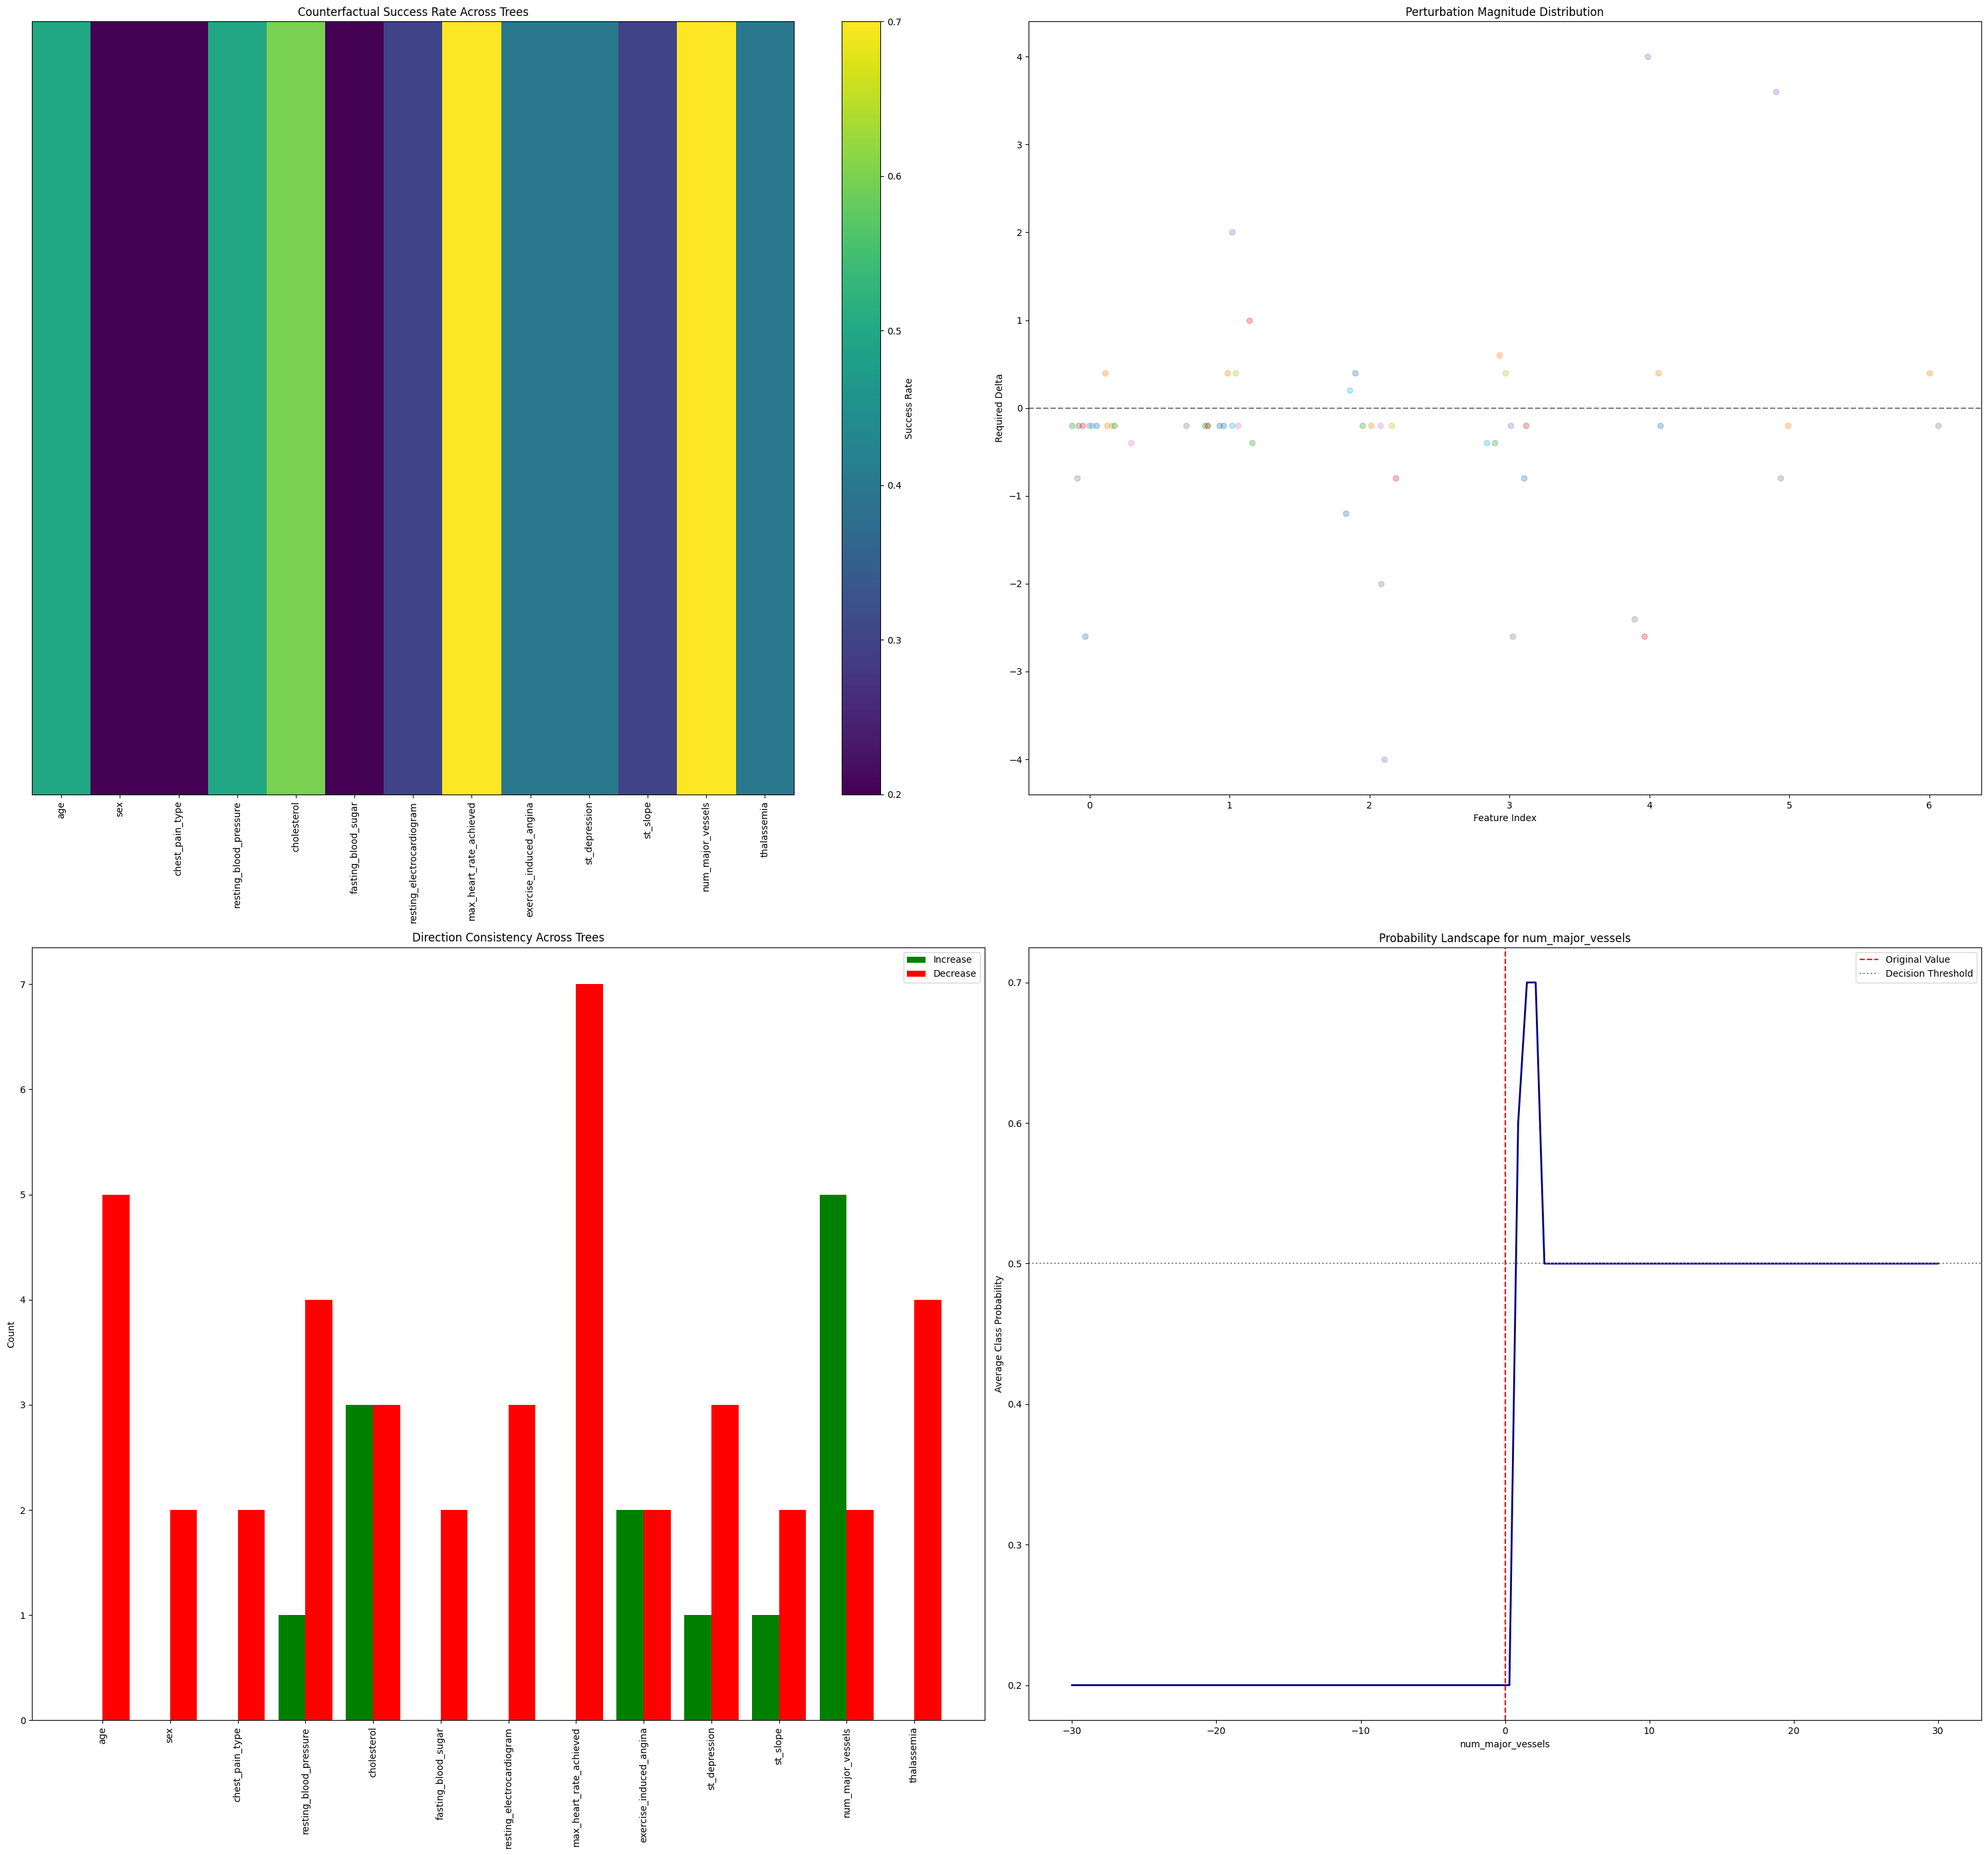

In [ ]:
# First get the global target class
instance = X.iloc[20].values
forest_pred = rf.predict(instance.reshape(1, -1))[0]
target_class = 1 - forest_pred  # Flip the prediction

agg_results, tree_data = ensemble_counterfactual_analysis(
    instance=instance,
    rf_model=rf,
    feature_names=list(X.columns),
    step=0.2,
    max_iter=50,
    target_class=target_class  # Explicit target class
)

## SHAP Analysis

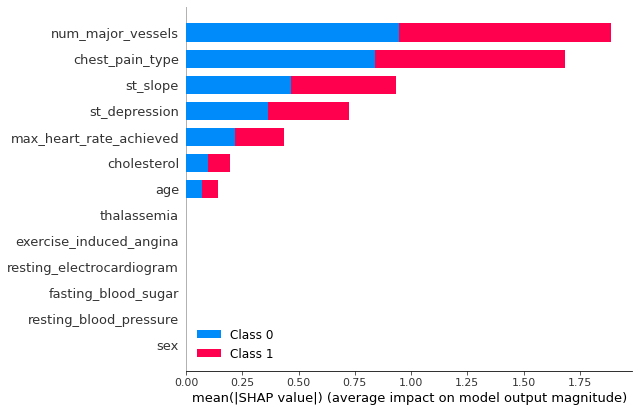


---

### **1. Core Methodological Components Explained**

#### **A. Per-Tree Analysis**
- **What it means**: The analysis evaluates counterfactual effectiveness _individually_ for every decision tree in the random forest. Each tree acts as a "mini-model" with its own decision logic.
- **Why it matters**: 
  - Identifies features that are universally important vs. those only significant in subsets of trees
  - Reveals the diversity of decision logic within the ensemble
  - Helps distinguish between *robust patterns* (agreed by most trees) and *idiosyncratic patterns* (specific to individual trees)

---

#### **B. Four Diagnostic Visualizations**
1. **Success Rate Heatmap**  
   - **Purpose**: Shows the percentage of trees where perturbing a feature flipped the prediction  
   - **Interpretation**:  
     - Bright colors = High success rates (e.g., "mean radius" flips predictions in 80% of trees)  
     - Dark colors = Low success rates (e.g., "texture" only affects 10% of trees)  
   - **Analogy**: A "voting system" showing which features are most influential across the ensemble  

2. **Perturbation Magnitude Distribution**  
   - **Purpose**: Visualizes the range of changes needed to flip predictions  
   - **Key Patterns**:  
     - Tight cluster = Consistent perturbation size across trees (e.g., "radius" always requires ~0.5 unit change)  
     - Wide spread = Context-dependent effectiveness (e.g., "area" needs 0.2-3.0 units depending on the tree)  
   - **Critical Insight**: Features with small required changes are "leverage points" for interventions  

3. **Direction Consistency Plot**  
   - **Purpose**: Quantifies whether features require consistent increase/decrease across trees  
   - **Example**:  
     - "Concavity": 90% of trees require decreasing this feature  
     - "Smoothness": 50% increase / 50% decrease (no consensus)  
   - **Implications**: Consistent directions indicate stable relationships between features and outcomes  

4. **Decision Boundary Projection**  
   - **Purpose**: Illustrates how the top feature's values relate to class probabilities  
   - **Key Observations**:  
     - Steep slope = Small changes dramatically affect predictions  
     - Flat region = Feature changes have minimal impact  
     - Distance from boundary = How "deep" the instance is in its predicted class  

---

#### **C. Aggregate Statistics**
1. **Success Rates**:  
   - "75% success rate for radius" = 3/4 trees would flip prediction if radius is perturbed  
   - Low rates (<20%) suggest the feature is either:  
     - Irrelevant to the classification  
     - Requires coordinated changes with other features  

2. **Required Perturbation Magnitudes**:  
   - Mean/median values indicate "typical" intervention size  
   - Large standard deviation implies tree-to-tree variability in feature sensitivity  

3. **Direction Consistency**:  
   - "85% consistency for decreasing radius" = Strong consensus on relationship direction  
   - 50/50 split = Ambiguous/noise in the feature's role  

---

### **2. Interpretation Guide Deep Dive**

#### **A. No Counterfactuals Detected**
- **Scenario**: All features show success rates <20%, sparse perturbation points, and distant decision boundaries  
- **Implications**:  
  1. **Model Robustness**: The prediction is stable against single-feature perturbations  
  2. **Data Characteristics**:  
     - The instance is far from class boundaries in feature space  
     - True decision boundaries may be multi-dimensional (require combined feature changes)  
  3. **Practical Impact**:  
     - Single-feature interventions may be insufficient  
     - Need to consider *minimum viable combination* of changes  

---

#### **B. Key Insights**
1. **High Success Rate Features**  
   - **Example**: "Radius" with 80% success rate  
   - **Actionable Insight**: Medical diagnosis - Focus on reducing tumor radius  
   - **Technical Implication**: The feature is central to the model's decision logic  

2. **Directional Consistency**  
   - **Example**: 90% of trees require decreasing "concavity"  
   - **Domain Significance**: Confirms biological understanding (less concave tumors are benign)  
   - **Validation**: Matches medical literature, increasing trust in the model  

3. **Large Required Perturbations**  
   - **Example**: "Area" needing >5-unit changes  
   - **Possible Causes**:  
     - The feature is scaled poorly (e.g., range=0-1000 vs. 0-1 for others)  
     - The model uses it only in extreme cases (threshold effect)  
   - **Solution Path**:  
     - Re-examine feature engineering  
     - Check for nonlinear relationships (log-transform?)  

---

### **3. Why This Matters for Explainability**
1. **Model Diagnostics**:  
   - Reveals whether the model uses features in medically/biologically plausible ways  
   - Detects over-reliance on non-actionable features (e.g., "patient ID")  

2. **Actionable Interventions**:  
   - Identifies features where small changes yield prediction flips (practical for real-world use)  
   - Warns against futile single-feature interventions when success rates are low  

3. **Trust & Validation**:  
   - Directional consistency with domain knowledge increases model credibility  
   - Inconsistencies flag potential data leakage or artifacts  

---

### **Real-World Analogy: Medical Diagnosis**
Imagine a tumor classifier where:
- **High Success Rate**: "Radius" (easy to measure, clearly malignant if large)  
- **Directional Consistency**: All doctors agree "larger = worse"  
- **Large Deltas**: "Texture" requires extreme changes to matter (rare edge cases)  

This analysis helps clinicians:
1. Focus on measurable, impactful features  
2. Avoid wasting time on ambiguous characteristics  
3. Understand when combined factors must be addressed  

By linking model behavior to domain reality, it bridges the gap between ML outputs and practical decision-making.